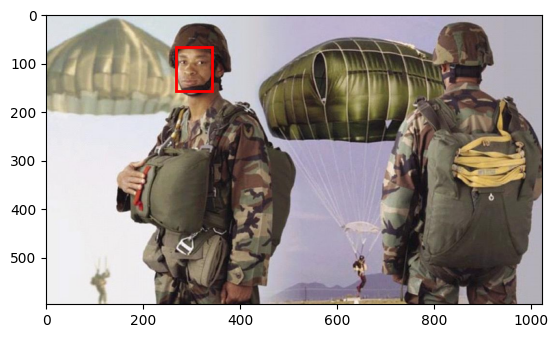

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def plot_image_with_bboxes(image_path, bboxes):
    """
    Plots an image with bounding boxes.

    Parameters:
    image_path (str): The path of the image file.
    bboxes (list of lists): A list of bounding boxes, each box is a list of [x, y, width, height].
    """
    # Charger l'image
    img = Image.open(image_path)

    # Créer une figure matplotlib et un axe
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Dessiner chaque bounding box
    for bbox in bboxes:
        x, y, width, height = bbox
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

plot_image_with_bboxes('../data/images/48--Parachutist_Paratrooper/48_Parachutist_Paratrooper_Parachutist_Paratrooper_48_781.jpg', [[268,66,74,90]])

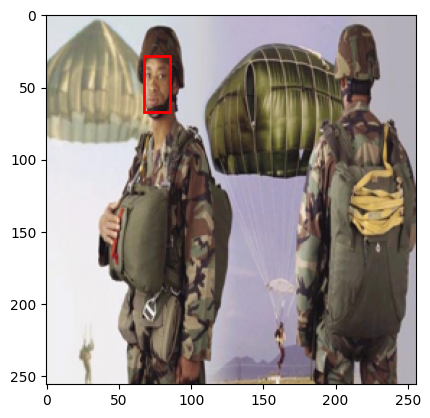

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


def resize_and_plot_bboxes(image_path, bboxes):
    """
    Resize an image to 256x256 and plot it with resized bounding boxes.

    Parameters:
    image_path (str): The path of the image file.
    bboxes (list of lists): A list of bounding boxes, each box is a list of [x, y, width, height].
    """
    # Charger et redimensionner l'image
    img = Image.open(image_path)
    original_size = img.size
    img_resized = img.resize((256, 256))

    # Calculer les facteurs de mise à l'échelle
    scale_x = 256 / original_size[0]
    scale_y = 256 / original_size[1]

    # Ajuster les bounding boxes
    resized_bboxes = []
    for bbox in bboxes:
        x, y, width, height = bbox
        new_x = x * scale_x
        new_y = y * scale_y
        new_width = width * scale_x
        new_height = height * scale_y
        resized_bboxes.append([new_x, new_y, new_width, new_height])


    # Afficher l'image et les bounding boxes
    fig, ax = plt.subplots(1)
    ax.imshow(img_resized)

    for bbox in resized_bboxes:
        x, y, width, height = bbox
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

resize_and_plot_bboxes('../data/images/48--Parachutist_Paratrooper/48_Parachutist_Paratrooper_Parachutist_Paratrooper_48_781.jpg', [[268,66,74,90]])


In [3]:
import numpy as np

import torch
from torchvision import transforms
from PIL import Image
import numpy as np

def preprocess_image_bbox(image_path, bboxes, fixed_bbox_count=50):
    # Load and resize the image
    img = Image.open(image_path)
    original_size = img.size
    img_resized = img.resize((256, 256))

    # Calculate scaling factors
    scale_x = 256 / original_size[0]
    scale_y = 256 / original_size[1]

    # Convert bboxes to numpy array for vectorized operations
    bbox_array = np.array(bboxes)
    scale_array = np.array([scale_x, scale_y, scale_x, scale_y])

    # Resize bounding boxes
    resized_bbox_array = bbox_array * scale_array

    # Padding or truncating the list of bounding boxes to fixed_bbox_count
    current_count = len(resized_bbox_array)
    if current_count < fixed_bbox_count:
        # If less, pad with zeros
        padding = np.zeros((fixed_bbox_count - current_count, 4))
        resized_bbox_array = np.vstack((resized_bbox_array, padding))
    elif current_count > fixed_bbox_count:
        # If more, truncate the array
        resized_bbox_array = resized_bbox_array[:fixed_bbox_count, :]

    # Convert the image to a numpy array
    img_array = np.asarray(img_resized, dtype=np.float32)

    # Convert the numpy array to a PyTorch tensor
    img_tensor = torch.from_numpy(img_array)

    # Reshape and normalize the tensor
    #dd a dimension for channels and reorder dimensions to CxHxW
    img_tensor = img_tensor.permute(2, 0, 1)
    
    # Normalize the tensor 
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img_tensor_normalized = normalize(img_tensor / 255.)

    # Convert the bounding boxes to a PyTorch tensor
    bbox_tensor = torch.from_numpy(resized_bbox_array).float()

    return img_tensor_normalized, bbox_tensor

img_tensor, bbox_tensor = preprocess_image_bbox('../data/images/48--Parachutist_Paratrooper/48_Parachutist_Paratrooper_Parachutist_Paratrooper_48_781.jpg', [[268,66,74,90]])

print(img_tensor.shape)
print(bbox_tensor.shape)

torch.Size([3, 256, 256])
torch.Size([50, 4])


In [4]:
import os

def load_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    images = []
    bbox_data = []
    current_bboxes = []

    for line in lines:
        line = line.strip()
        if line.endswith('.jpg'):
            if current_bboxes:
                images.append(current_image)
                bbox_data.append(current_bboxes)
                current_bboxes = []
            current_image = line
        elif line.isdigit():
            continue
        else:
            bbox = list(map(int, line.split()[:4]))  
            current_bboxes.append(bbox)

    if current_bboxes:
        images.append(current_image)
        bbox_data.append(current_bboxes)

    return images, bbox_data

images, bbox_data = load_data('../data/bounding_boxes/wider_faceseglite_bbx.txt')

In [5]:
BBOX_PREDICTED = 5
BATCH_SIZE = 16

In [6]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, images, bbox_data, root_dir, transform=None):
        self.images = images
        self.bbox_data = bbox_data
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image, bboxes = preprocess_image_bbox(img_name, self.bbox_data[idx], fixed_bbox_count=BBOX_PREDICTED)
        sample = {'image': image, 'bboxes': bboxes}

        if self.transform:
            sample = self.transform(sample)

        return sample


In [7]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_bbox_data, test_bbox_data = train_test_split(images, bbox_data, test_size=0.2, random_state=42)

train_dataset = CustomDataset(train_images, train_bbox_data, '../data/images', transform=None)
test_dataset = CustomDataset(test_images, test_bbox_data, '../data/images', transform=None)

In [42]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 128)
        # 4 pour les coordonnées de la boîte et x pour le nombre de classes
        self.fc3 = nn.Linear(128, BBOX_PREDICTED * 4) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Pas d'activation, car c'est une régression
        x = x.view(-1, BBOX_PREDICTED, 4)  # Redimensionner pour obtenir 50 boîtes avec 4 coordonnées et 1 score
        return x

model = SimpleCNN()


In [9]:
from torch.nn import Dropout
from torch.nn import Identity
from torch.nn import Linear
from torch.nn import Module
from torch.nn import ReLU
from torch.nn import Sequential
from torch.nn import Sigmoid

class ObjectDetector(Module):
    def __init__(self, baseModel, numClasses, numBoxes=50):
        super(ObjectDetector, self).__init__()
        # initialize the base model, the number of classes, and the number of bounding boxes
        self.baseModel = baseModel
        self.numClasses = numClasses
        self.numBoxes = numBoxes

        # build the regressor head for outputting bounding box coordinates
        self.regressor = Sequential(
            Linear(baseModel.fc.in_features, 128),
            ReLU(),
            Linear(128, 64),
            ReLU(),
            Linear(64, 32),
            ReLU(),
            Linear(32, 4 * self.numBoxes),  # Output 4 * numBoxes values
            Sigmoid()
        )

        self.classifier = Sequential(
            Linear(baseModel.fc.in_features, 512),
            ReLU(),
            Dropout(),
            Linear(512, 512),
            ReLU(),
            Dropout(),
            Linear(512, self.numClasses * self.numBoxes)  # Output numClasses * numBoxes values
        )

        # set the classifier of our base model to produce outputs from the last convolution block
        self.baseModel.fc = Identity()

    def forward(self, x):
        # pass the inputs through the base model and then obtain predictions from two different branches of the network
        features = self.baseModel(x)
        bboxes = self.regressor(features).view(-1, self.numBoxes, 4)  # Reshape to (batch_size, numBoxes, 4)
        classLogits = self.classifier(features).view(-1, self.numClasses, self.numBoxes)  # Reshape to (batch_size, numClasses, numBoxes)

        # return the outputs as a tuple
        return (bboxes, classLogits)

In [10]:
from torchvision.models import resnet50

num_classes = 2
# load the ResNet50 network
resnet = resnet50(pretrained=True)

# freeze all ResNet50 layers
for param in resnet.parameters():
    param.requires_grad = False

objectDetector = ObjectDetector(resnet, num_classes, BBOX_PREDICTED)

C:\Users\theot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\theot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
def bbox_iou(box1, box2):
    """
    Calcule l'Intersection sur Union (IoU) de deux boîtes englobantes.
    
    Args:
    - box1, box2: Tensor, chacun de la forme [..., 4]
    Les boîtes doivent être en format (x_center, y_center, largeur, hauteur).
    
    Returns:
    - iou: Tensor, IoU de chaque paire de boîtes.
    """
    # Coin supérieur gauche
    x1 = box1[..., 0] - box1[..., 2] / 2
    y1 = box1[..., 1] - box1[..., 3] / 2
    # Coin inférieur droit
    x2 = box1[..., 0] + box1[..., 2] / 2
    y2 = box1[..., 1] + box1[..., 3] / 2

    # Coin supérieur gauche de box2
    x1g = box2[..., 0] - box2[..., 2] / 2
    y1g = box2[..., 1] - box2[..., 3] / 2
    # Coin inférieur droit de box2
    x2g = box2[..., 0] + box2[..., 2] / 2
    y2g = box2[..., 1] + box2[..., 3] / 2

    # Intersection
    xi1 = torch.max(x1, x1g)
    yi1 = torch.max(y1, y1g)
    xi2 = torch.min(x2, x2g)
    yi2 = torch.min(y2, y2g)
    inter_area = torch.clamp(xi2 - xi1, min=0) * torch.clamp(yi2 - yi1, min=0)

    # Union
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)
    union_area = box1_area + box2_area - inter_area

    # IoU
    iou = inter_area / union_area
    
    return iou


def custom_loss(output, target):
    # Assurez-vous que les dimensions de 'output' et 'target' sont correctes
    # output et target devraient être de la forme [batch_size, 50, 4]
    
    # Calculer l'IoU pour chaque boîte
    iou = bbox_iou(output, target)
    
    # Perte 1 - moyenne IoU
    loss = 1 - iou.mean()
    
    return loss

In [44]:
import torch.optim as optim

optimizer = optim.Adam(objectDetector.parameters(), lr=0.001)
criterion = nn.MSELoss()

num_epochs = 10
losses = []
#ADD TRACKING OF LOSS
for epoch in range(num_epochs):
    objectDetector.train()
    for i, data in enumerate(DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True), 0):
        inputs, labels = data['image'], data['bboxes']
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = custom_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if i % 10 == 0:
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {loss.item()}')
    torch.save(objectDetector.state_dict(), f'../models/img_to_bbox_resnet_v2{epoch}.pth')





Epoch 1, Batch 1, Loss: 1.0
Epoch 1, Batch 11, Loss: 1.0
Epoch 1, Batch 21, Loss: 1.0
Epoch 1, Batch 31, Loss: 1.0
Epoch 1, Batch 41, Loss: 1.0
Epoch 1, Batch 51, Loss: 1.0
Epoch 1, Batch 61, Loss: 1.0
Epoch 1, Batch 71, Loss: 1.0
Epoch 1, Batch 81, Loss: 1.0
Epoch 1, Batch 91, Loss: 1.0
Epoch 1, Batch 101, Loss: 1.0
Epoch 1, Batch 111, Loss: 1.0
Epoch 1, Batch 121, Loss: 1.0
Epoch 1, Batch 131, Loss: 1.0
Epoch 1, Batch 141, Loss: 1.0
Epoch 1, Batch 151, Loss: 1.0
Epoch 1, Batch 161, Loss: 1.0
Epoch 1, Batch 171, Loss: 1.0
Epoch 1, Batch 181, Loss: 1.0
Epoch 1, Batch 191, Loss: 1.0
Epoch 1, Batch 201, Loss: 1.0
Epoch 1, Batch 211, Loss: 1.0
Epoch 1, Batch 221, Loss: 1.0
Epoch 1, Batch 231, Loss: 1.0
Epoch 1, Batch 241, Loss: 1.0
Epoch 1, Batch 251, Loss: 1.0
Epoch 1, Batch 261, Loss: 1.0
Epoch 1, Batch 271, Loss: 1.0
Epoch 1, Batch 281, Loss: 1.0
Epoch 1, Batch 291, Loss: 1.0
Epoch 1, Batch 301, Loss: 1.0
Epoch 1, Batch 311, Loss: 1.0
Epoch 1, Batch 321, Loss: 1.0
Epoch 1, Batch 331, L

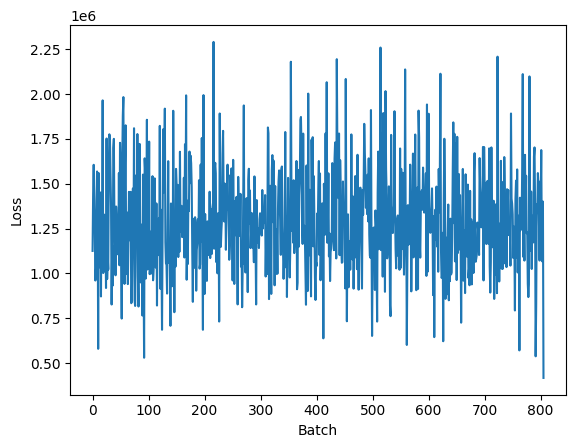

In [14]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()


In [29]:
#load the model

model = SimpleCNN()
model.load_state_dict(torch.load('../models/img_to_bbox_v25.pth'))

<All keys matched successfully>

In [30]:
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data['image'], data['bboxes']
            outputs = model(inputs)
            test_loss += custom_loss(outputs[0], labels).item()
    return test_loss / len(test_loader)

In [31]:
test_loss = evaluate_model(model, DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True))

C:\Users\theot\AppData\Local\Temp\ipykernel_5684\2468486135.py:6: UserWarning: Using a target size (torch.Size([16, 5, 4])) that is different to the input size (torch.Size([5, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  regression_loss = F.mse_loss(output, target, reduction='sum')
C:\Users\theot\AppData\Local\Temp\ipykernel_5684\2468486135.py:6: UserWarning: Using a target size (torch.Size([5, 5, 4])) that is different to the input size (torch.Size([5, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  regression_loss = F.mse_loss(output, target, reduction='sum')


In [32]:
print(f'Test loss: {test_loss}')

Test loss: 931274.0218904703


In [33]:
def preprocess_image(image_path):
    # Load and resize the image
    img = Image.open(image_path)
    original_size = img.size
    img_resized = img.resize((256, 256))

    # Convert the image to a numpy array
    img_array = np.asarray(img_resized, dtype=np.float32)

    # Convert the numpy array to a PyTorch tensor
    img_tensor = torch.from_numpy(img_array)

    # Reshape and normalize the tensor
    # Add a dimension for channels and reorder dimensions to CxHxW
    img_tensor = img_tensor.permute(2, 0, 1)

    # Normalize the tensor
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img_tensor_normalized = normalize(img_tensor / 255.)

    return img_tensor_normalized

def predict_bounding_box(image_path, model, truth_bboxes=None):
    """
    Plots an image with bounding boxes.

    Parameters:
    image_path (str): The path of the image file.
    bboxes (list of lists): A list of bounding boxes, each box is a list of [x, y, width, height].
    """
    # Charger et redimensionner l'image
    img = Image.open(image_path)
    original_size = img.size
    img_resized = img.resize((256, 256))

    # Calculer les facteurs de mise à l'échelle
    scale_x = 256 / original_size[0]
    scale_y = 256 / original_size[1]

    # Ajuster les bounding boxes
    resized_bboxes = []
    for bbox in truth_bboxes:
        x, y, width, height = bbox
        new_x = x * scale_x
        new_y = y * scale_y
        new_width = width * scale_x
        new_height = height * scale_y
        resized_bboxes.append([new_x, new_y, new_width, new_height])


    img_tensor = preprocess_image(image_path)

    # Make a prediction
    model.eval()
    with torch.no_grad():
        pred_bboxes = model(img_tensor.unsqueeze(0))
    

    # Afficher l'image et les bounding boxes
    fig, ax = plt.subplots(1)
    ax.imshow(img_resized)

    for bbox in resized_bboxes:
        x, y, width, height = bbox
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

    for bbox in pred_bboxes[0]:
        x, y, width, height = bbox
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

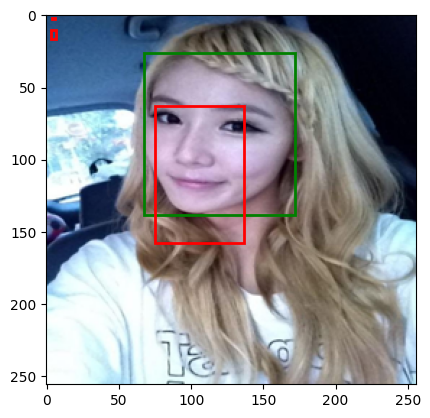

In [35]:
predict_bounding_box(f'../data/images/{test_images[0]}', model, test_bbox_data[0])

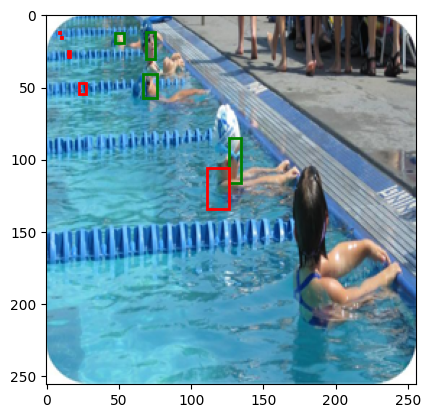

In [36]:
predict_bounding_box(f'../data/images/{test_images[50]}', model, test_bbox_data[50])

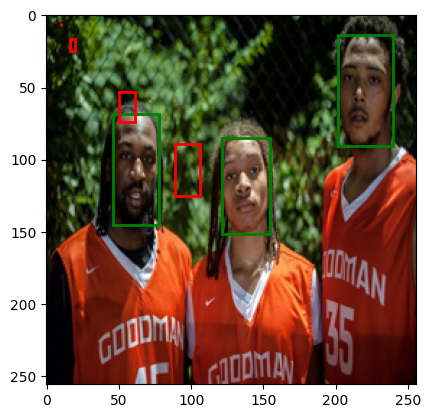

In [37]:
predict_bounding_box(f'../data/images/{test_images[100]}', model, test_bbox_data[100])

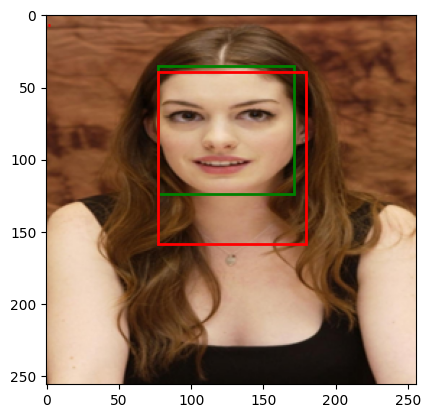

In [38]:
predict_bounding_box(f'../data/images/{test_images[200]}', model, test_bbox_data[200])